# Configuración del entorno



*   Descargar entorno, ficheros, scripts, codigo y dataset de Github
*   Importacion de librerias



In [1]:
!git clone  https://github.com/omar-ogm/keras-ssd 

%cd "/content/keras-ssd"

from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import pickle

from SSD300.ssd_v2 import SSD300v2
from SSD300.ssd_training import MultiboxLoss
from SSD300.ssd_utils import BBoxUtility

from get_data_from_XML import XML_preprocessor
from generator import Generator



Cloning into 'keras-ssd'...
remote: Enumerating objects: 822, done.
remote: Counting objects: 100% (822/822), done.
remote: Compressing objects: 100% (464/464), done.
remote: Total 822 (delta 358), reused 820 (delta 356), pack-reused 0
Receiving objects: 100% (822/822), 8.11 MiB | 23.08 MiB/s, done.
Resolving deltas: 100% (358/358), done.
/content/keras-ssd


Using TensorFlow backend.


# Carga del modelo SSD300


*   Creacion del modelo
*   Determinar el numero de clases
*  Eleccion de la funcion de perdida
*  Eleccion del optimizador




In [0]:
voc_classes = ['RBC', 'WBC', 'Platelets']
NUM_CLASSES = len(voc_classes) + 1
input_shape = (300, 300, 3) #Se puede aumentar para tener mas precision


model = SSD300v2(input_shape, num_classes=NUM_CLASSES)

loss = MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss

model.compile(optimizer='Adam', loss=loss,  metrics=['accuracy']) 
  
  
#https://keras.io/metrics/
#model.compile(optimizer='Adadelta', loss=loss,  metrics=['accuracy']) 
#Añadir mAp en metrics, se pueden añadir métodos para que sean llamados cada vez
#tambien añadir la IoU media o algo así si no es mucho lio

# model.summary()

# Preprocesado 

*   Carga de los prior boxes segun el Paper original. 7308 prior boxes
*   Generacion del groundtruth parseando el XML a formato [class x y width height]




In [0]:
priors = pickle.load(open('./SSD300/prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [0]:
#Converts from VOC .xml Annotations to labels format (class x y width height)
voc_parser = XML_preprocessor(data_path='./dataset_rbc/train/Annotations/')

# Entrenamiento del modelo

### Creacion de generador de muestra y entrenamiento

In [0]:
from sklearn.model_selection import train_test_split

EPOCHS = 32
BATCH_SIZE = 16

keys = list(voc_parser.data.keys())

train_keys, val_keys = train_test_split(keys, test_size=0.20, random_state=42) #Shuffle and split the data

# Creamos un generator, para ir pasando las imagenes poco a poco y en caso de querer poder aplicar data augmentation sobre la muestra.
# NOTA: Al generator se le pasa el groundtruth de la muestra completa, al ser un diccionario, internamente es capaz de recuperar el groundtruth para cada dato de train y test. 
# En conclusion no es necesario hacer el split para el Y o groundtruth, tan solo para las imagenes
gen = Generator(gt=voc_parser.data, bbox_util=bbox_util,
               batch_size=BATCH_SIZE, path_prefix='./dataset_rbc/train/images/',
               train_keys=train_keys, val_keys=val_keys, image_size=(300, 300))
  
# El generador hace data augmentation sobre las muestras originales de forma aleatoria.
# Método generate() de Generator.py
# Submuestrea de forma aleatoria y selecciona una submuestra de tamaño batch_size de la original
# Aplica un recorte sobre la imagen original y le hace un resize a 300x300 para poder ser admitida por la red.
# De forma aleatoria aplica distintas transformaciones sobre la imagen resultante: flips, cambios en iluminacion, contraste...
# De la misma forma se recalculan los bbox del ground truth para que tengan sentido con la nueva muestra.
# Se hace esto mismo para la validación, de forma que los datos de validacion tambien son aleatorios.
# Esto hace que tengamos muestra "infinita", o al menos mucha mayor muestra que la que teniamos inicialmente la cual no era mucha.
  


### Entrenamiento

In [0]:
RUN = RUN + 1 if 'RUN' in locals() else 1

LOG_DIR = '/output/training_logs/run{}'.format(RUN)
LOG_FILE_PATH = LOG_DIR + '/checkpoint-{epoch:02d}-{val_loss:.4f}.hdf5'

tbCallBack = TensorBoard(log_dir=LOG_DIR, write_images=True)

# Vamos guardando todos aquellos modelos que consigan mejorar la val_loss.
checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True)
# Nos centramos en obtener un buen val_loss, en el momento en el que el val_loss deja de crecer durante varias epocas podemos asumir que es porque se ha llegado al punto donde la red 
# empieza a sobreentrenar.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
  
history = model.fit_generator(generator=gen.generate(True), steps_per_epoch=int(gen.train_batches / 4),
                               validation_data=gen.generate(False), validation_steps=int(gen.val_batches / 4),
                               epochs=EPOCHS, verbose=1, callbacks=[tbCallBack, checkpoint, early_stopping])

Epoch 1/32
 1/65 [..............................] - ETA: 2:26 - loss: 3.0006 - acc: 0.1316

/content/keras-ssd/SSD300/ssd_utils.py:114: RuntimeWarning: divide by zero encountered in log
  assigned_priors_wh)


65/65 [==============================] - 80s 1s/step - loss: 2.9155 - acc: 0.2348 - val_loss: 3.0125 - val_acc: 0.0207

Epoch 00001: val_loss improved from inf to 3.01251, saving model to /output/training_logs/run2/checkpoint-01-3.0125.hdf5
Epoch 2/32
65/65 [==============================] - 74s 1s/step - loss: 2.8021 - acc: 0.1167 - val_loss: 2.8599 - val_acc: 0.3276

Epoch 00002: val_loss improved from 3.01251 to 2.85987, saving model to /output/training_logs/run2/checkpoint-02-2.8599.hdf5
Epoch 3/32
65/65 [==============================] - 77s 1s/step - loss: 2.7624 - acc: 0.1337 - val_loss: 2.9315 - val_acc: 0.0096

Epoch 00003: val_loss did not improve from 2.85987
Epoch 4/32
65/65 [==============================] - 77s 1s/step - loss: 2.7705 - acc: 0.1939 - val_loss: 2.8558 - val_acc: 0.0408

Epoch 00004: val_loss improved from 2.85987 to 2.85583, saving model to /output/training_logs/run2/checkpoint-04-2.8558.hdf5
Epoch 5/32
65/65 [==============================] - 77s 1s/step -

# Testing the final model

## Load your best model

In [0]:
from keras.preprocessing import image
from scipy.misc import imread
from keras.applications.imagenet_utils import preprocess_input
import numpy as np

files = ['BloodImage_00178.jpg'] #Test data

inputs = []
images = []
for f in files:
    f = "./dataset/BCCD/images/" + f
    img = image.load_img(f, target_size=(300, 300))
    img = image.img_to_array(img)
    
    images.append(imread(f))
    inputs.append(img.copy())

inputs = preprocess_input(np.array(inputs))

preds = model.predict(inputs, batch_size=1, verbose=1)
# preds.shape (5, 7308, 16)
# 5=numero de imagenes ; 7308=Numero de anchor ; 16=tamaño de la prediccion por bbox. Para cada bbox (4+1+3)*2=16, Siendo 4 (x,y width height), 1 "confidence", 3 "num_classes", 2 predicciones por anchor

results = bbox_util.detection_out(preds) #Resultado para cada imagen de los bbox posibles.
# type(results): list, len(results): 5, len(result[0]): 200, results[0].shape: (200, 6)


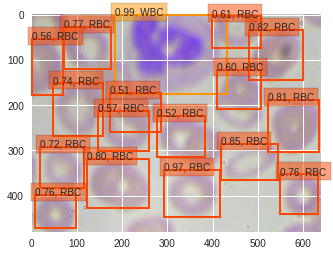

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.5.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.5]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()